In [17]:
import pandas as pd
from dp_transformer import DifferentialPrivacyTransformer
import numpy as np
import pandas as pd
from dp_mechanisms.quantitative import (
    duchi_mechanism,
    piecewise_mechanism,
    normalize_to_range,
    denormalize_from_range,
    laplace_mechanism,
    multidimensional_duchi_mechanism,
    multidimensional_mechanism
)
from dp_mechanisms.categorical import direct_encoding, optimized_unary_encoding, rappor
from dp_plotting import plot_mean_vs_privatized, plot_histograms
import torch

For this example, we will show how to apply the numerical methods of Local differential privacy. We implement 5 methods of Local Diferential privacy, the first method takes the clasic laplace method, 2. Piecewise Mechanism, duchi, multidimensional duchi, and the algorithm of the paper. In this notebook we will see all the methods aplied to a numerical vector and compare the distribution given the epsilon

Here we just import the libraries necesaries for the use of the class


In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn.metrics import mean_squared_error

#file_path = r"C:\Users\David\Universidad de los andes\David Stiven Romero Grajales - Trabajo de Grado\Trabajo de Grado 1\Base de datos y descripción\Entrenamiento_cronicas_N.csv"
#df_final = pd.read_csv(file_path)

#Mac_David
#file_path = '/Users/davidmoreno/Library/CloudStorage/OneDrive-SharedLibraries-Universidaddelosandes/David Stiven Romero Grajales - Trabajo de Grado/Trabajo de Grado 1/Base de datos y descripción/Titanic/Titanic-Dataset.csv'

# Load the train and test datasets
file_path_train = r"C:\Users\David\Universidad de los andes\David Stiven Romero Grajales - Trabajo de Grado\Trabajo de Grado 1\Base de datos y descripción\Titanic\train.csv"
file_path_test = r"C:\Users\David\Universidad de los andes\David Stiven Romero Grajales - Trabajo de Grado\Trabajo de Grado 1\Base de datos y descripción\Titanic\test.csv"
titanic_data_train = pd.read_csv(file_path_train)
titanic_data_test = pd.read_csv(file_path_test)

# Store the original index lengths to separate data later
train_length = len(titanic_data_train)
test_length = len(titanic_data_test)

# Concatenate train and test datasets to ensure consistent cleaning
titanic_data = pd.concat([titanic_data_train, titanic_data_test], axis=0, ignore_index=True)

# Drop columns with excessive missing values or those less likely to be relevant
titanic_data.drop(columns=['Ticket', 'Cabin'], inplace=True)

# Handle missing values
# Fill missing values for 'Age' with the median
titanic_data['Age'].fillna(titanic_data['Age'].median(), inplace=True)

# Fill missing values for 'Embarked' with the mode
titanic_data['Embarked'].fillna(titanic_data['Embarked'].mode()[0], inplace=True)

# Fill missing values for 'Fare' with the median value
titanic_data['Fare'].fillna(titanic_data['Fare'].median(), inplace=True)

# Convert categorical columns to numerical (e.g., 'Sex' and 'Embarked')
titanic_data['Sex'] = titanic_data['Sex'].map({'male': 0, 'female': 1})
titanic_data = pd.get_dummies(titanic_data, columns=['Embarked'], drop_first=True)

# Separate the cleaned train and test data based on the original lengths
titanic_data_train_cleaned = titanic_data.iloc[:train_length, :].copy()
titanic_data_test_cleaned = titanic_data.iloc[train_length:, :].copy()

# Reset index for cleaned train and test data
titanic_data_train_cleaned.reset_index(drop=True, inplace=True)
titanic_data_test_cleaned.reset_index(drop=True, inplace=True)

# Save cleaned data to CSV files if needed
#titanic_data_train_cleaned.to_csv('train_cleaned.csv', index=False)
#titanic_data_test_cleaned.to_csv('test_cleaned.csv', index=False)

#print("Data cleaned and saved as train_cleaned.csv and test_cleaned.csv")



C:\Users\David\AppData\Local\Temp\ipykernel_18584\270080404.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data['Age'].fillna(titanic_data['Age'].median(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_18584\270080404.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

In [19]:
age_data = titanic_data_train_cleaned['Age']

Lets see the original Plot of the data

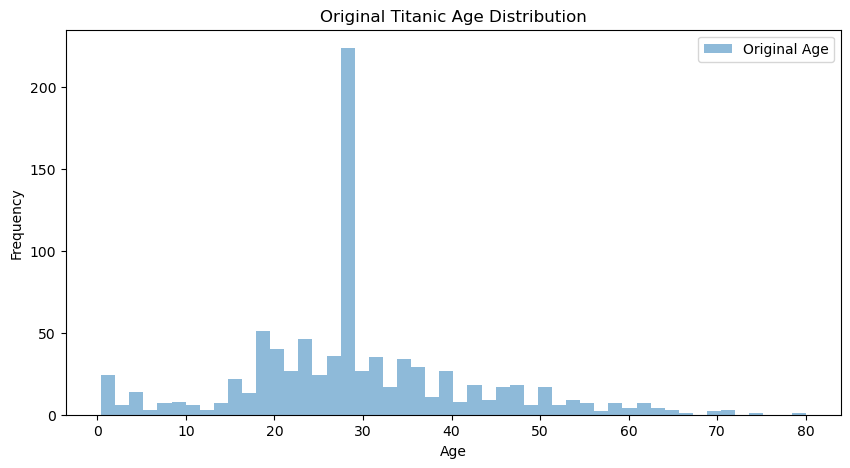

In [20]:
# Plot original Age data
plt.figure(figsize=(10, 5))
plt.hist(age_data, bins=50, alpha=0.5, label='Original Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Original Titanic Age Distribution')
plt.legend()
plt.show()

All of this algorithms need a transformation before the data wee need to have the data in the range [-1,1] so first we need to use this function

In [21]:
age_tensor = torch.tensor(age_data.values, dtype=torch.float32)
age_normalized, min_age, max_age = normalize_to_range(age_tensor)



First we will want to see the Laplace Mechanism

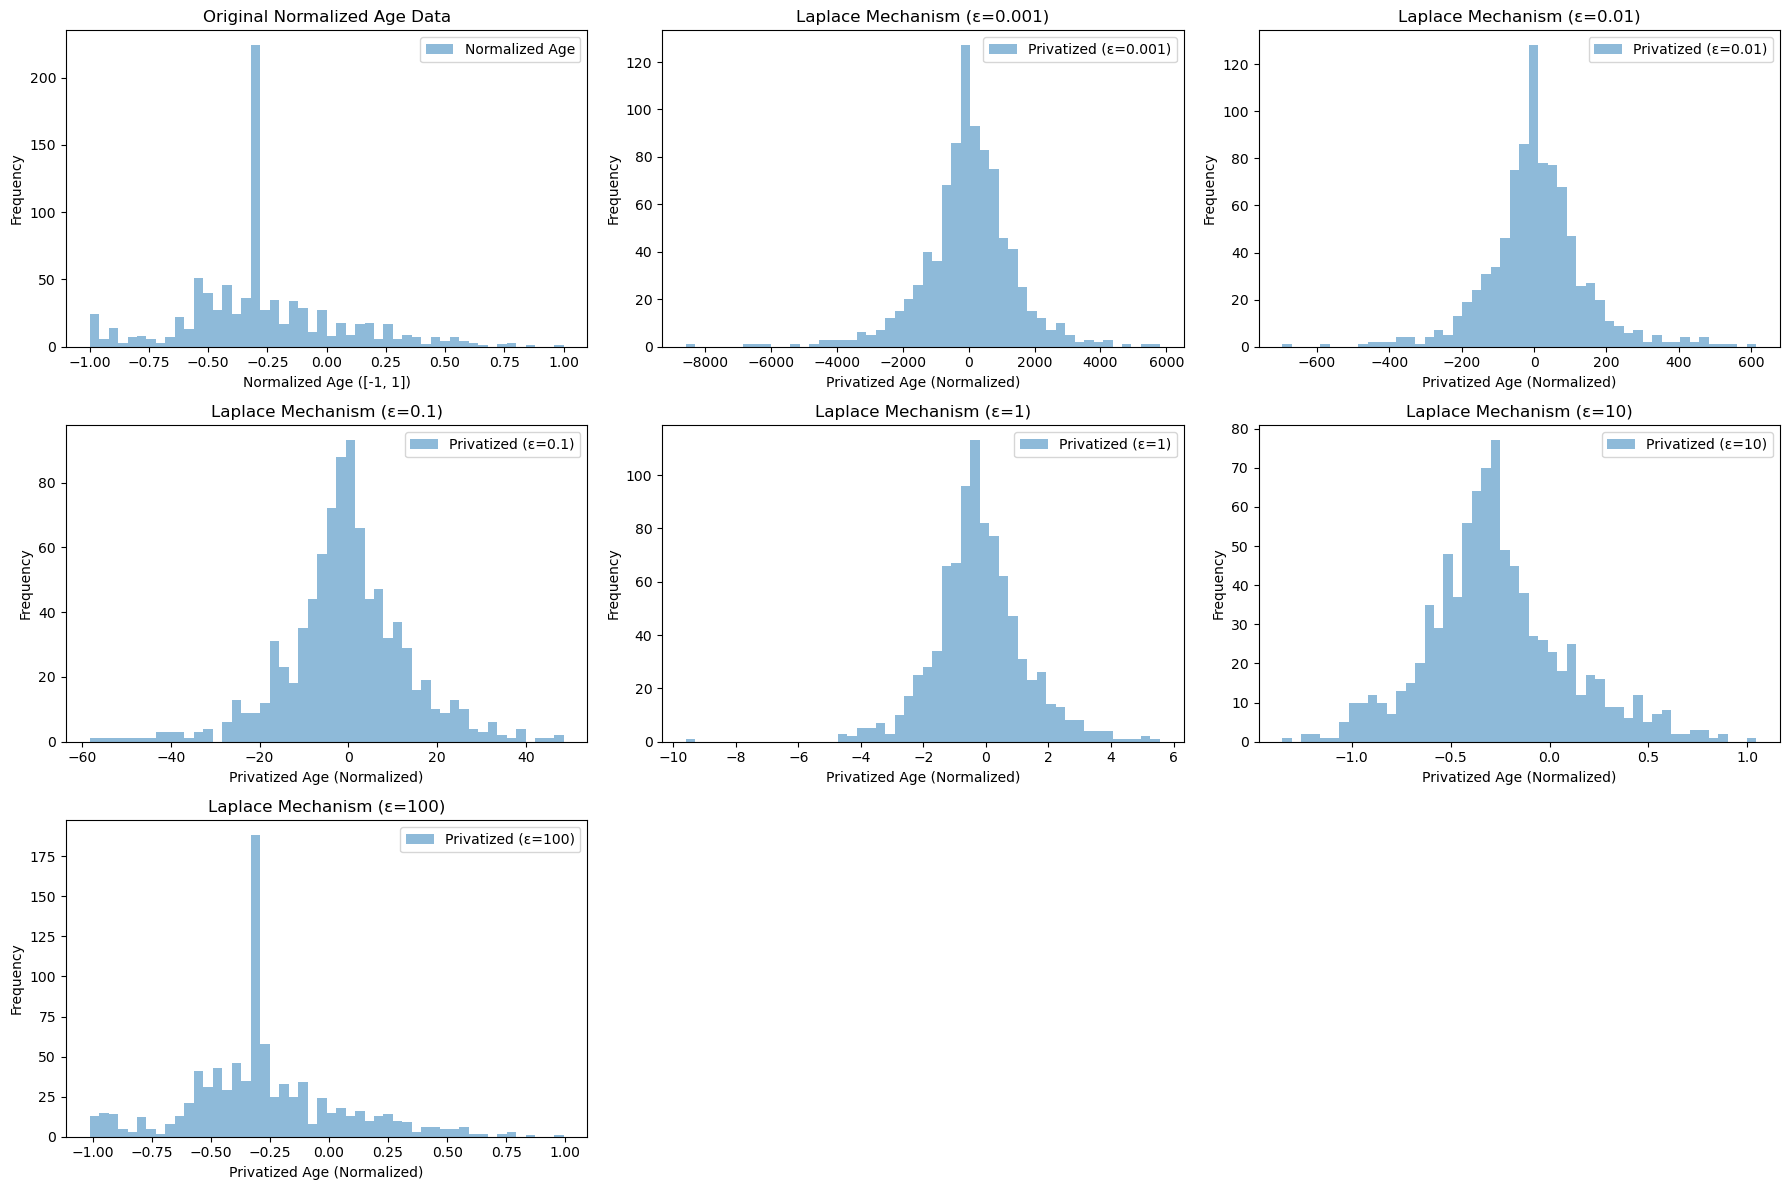

In [22]:
# Set different epsilon values to observe the effect
epsilon_values = [0.001, 0.01, 0.1, 1, 10,100]

# Plotting
plt.figure(figsize=(18, 12))
plt.subplot(3, 3, 1)
plt.hist(age_normalized.numpy(), bins=50, alpha=0.5, label='Normalized Age')
plt.xlabel('Normalized Age ([-1, 1])')
plt.ylabel('Frequency')
plt.title('Original Normalized Age Data')
plt.legend()

# Apply Duchi Mechanism for each epsilon and plot
for i, epsilon in enumerate(epsilon_values, start=2):
    duchi_priv = laplace_mechanism(age_normalized, epsilon)
    plt.subplot(3, 3, i)
    plt.hist(duchi_priv.numpy(), bins=50, alpha=0.5, label=f'Privatized (ε={epsilon})')
    plt.xlabel('Privatized Age (Normalized)')
    plt.ylabel('Frequency')
    plt.title(f'Laplace Mechanism (ε={epsilon})')
    plt.legend()

plt.tight_layout()
plt.show()

Here we can see how the distribution change, and how the lenghth of the interval changes, wee see as the epsilon i super low, we have values really big at the end of the distribution, and when the epislon increases the interval became more short having almos the same distribution as the normal without anything for this example, and when we have a big epsilon we have almost exaclty the same distribution

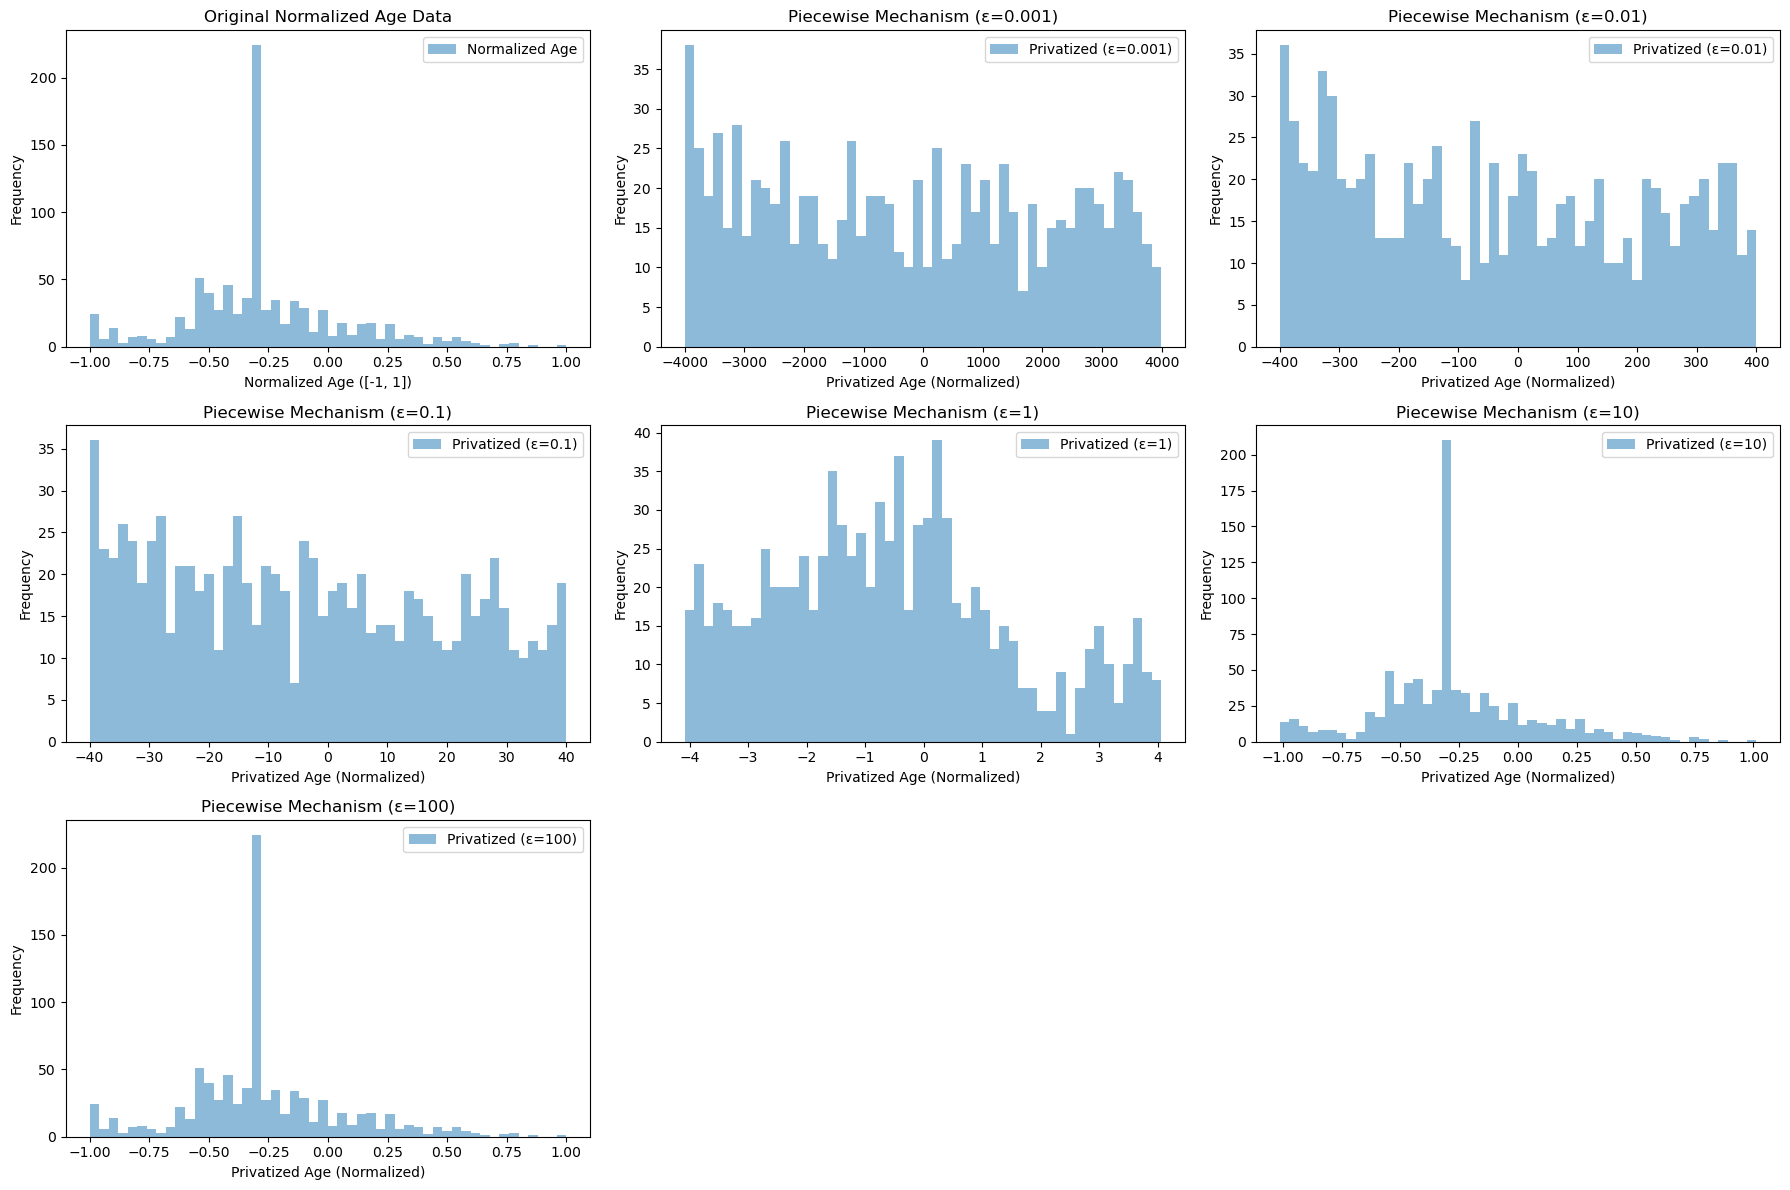

In [23]:
# Set different epsilon values to observe the effect
epsilon_values = [0.001, 0.01, 0.1, 1, 10, 100]

# Plotting
plt.figure(figsize=(18, 12))
plt.subplot(3, 3, 1)
plt.hist(age_normalized.numpy(), bins=50, alpha=0.5, label='Normalized Age')
plt.xlabel('Normalized Age ([-1, 1])')
plt.ylabel('Frequency')
plt.title('Original Normalized Age Data')
plt.legend()

# Apply Duchi Mechanism for each epsilon and plot
for i, epsilon in enumerate(epsilon_values, start=2):
    duchi_priv = piecewise_mechanism(age_normalized, epsilon)
    plt.subplot(3, 3, i)
    plt.hist(duchi_priv.numpy(), bins=50, alpha=0.5, label=f'Privatized (ε={epsilon})')
    plt.xlabel('Privatized Age (Normalized)')
    plt.ylabel('Frequency')
    plt.title(f'Piecewise Mechanism (ε={epsilon})')
    plt.legend()

plt.tight_layout()
plt.show()

Here we see a better algorith, we see it convergest faster than the clasic laplace method, for example at epsilon=10 we had almos the same distribution that we had before, also the noise is more pronounce as a uniform variables, that coud be one of the reasons why this method could bring better result on the aplication of this algoritms

ε=0.001: -2.2447
ε=0.01: -19.0798
ε=0.1: -0.0674
ε=1: -0.2356
ε=10: -0.2279
ε=100: -0.2278


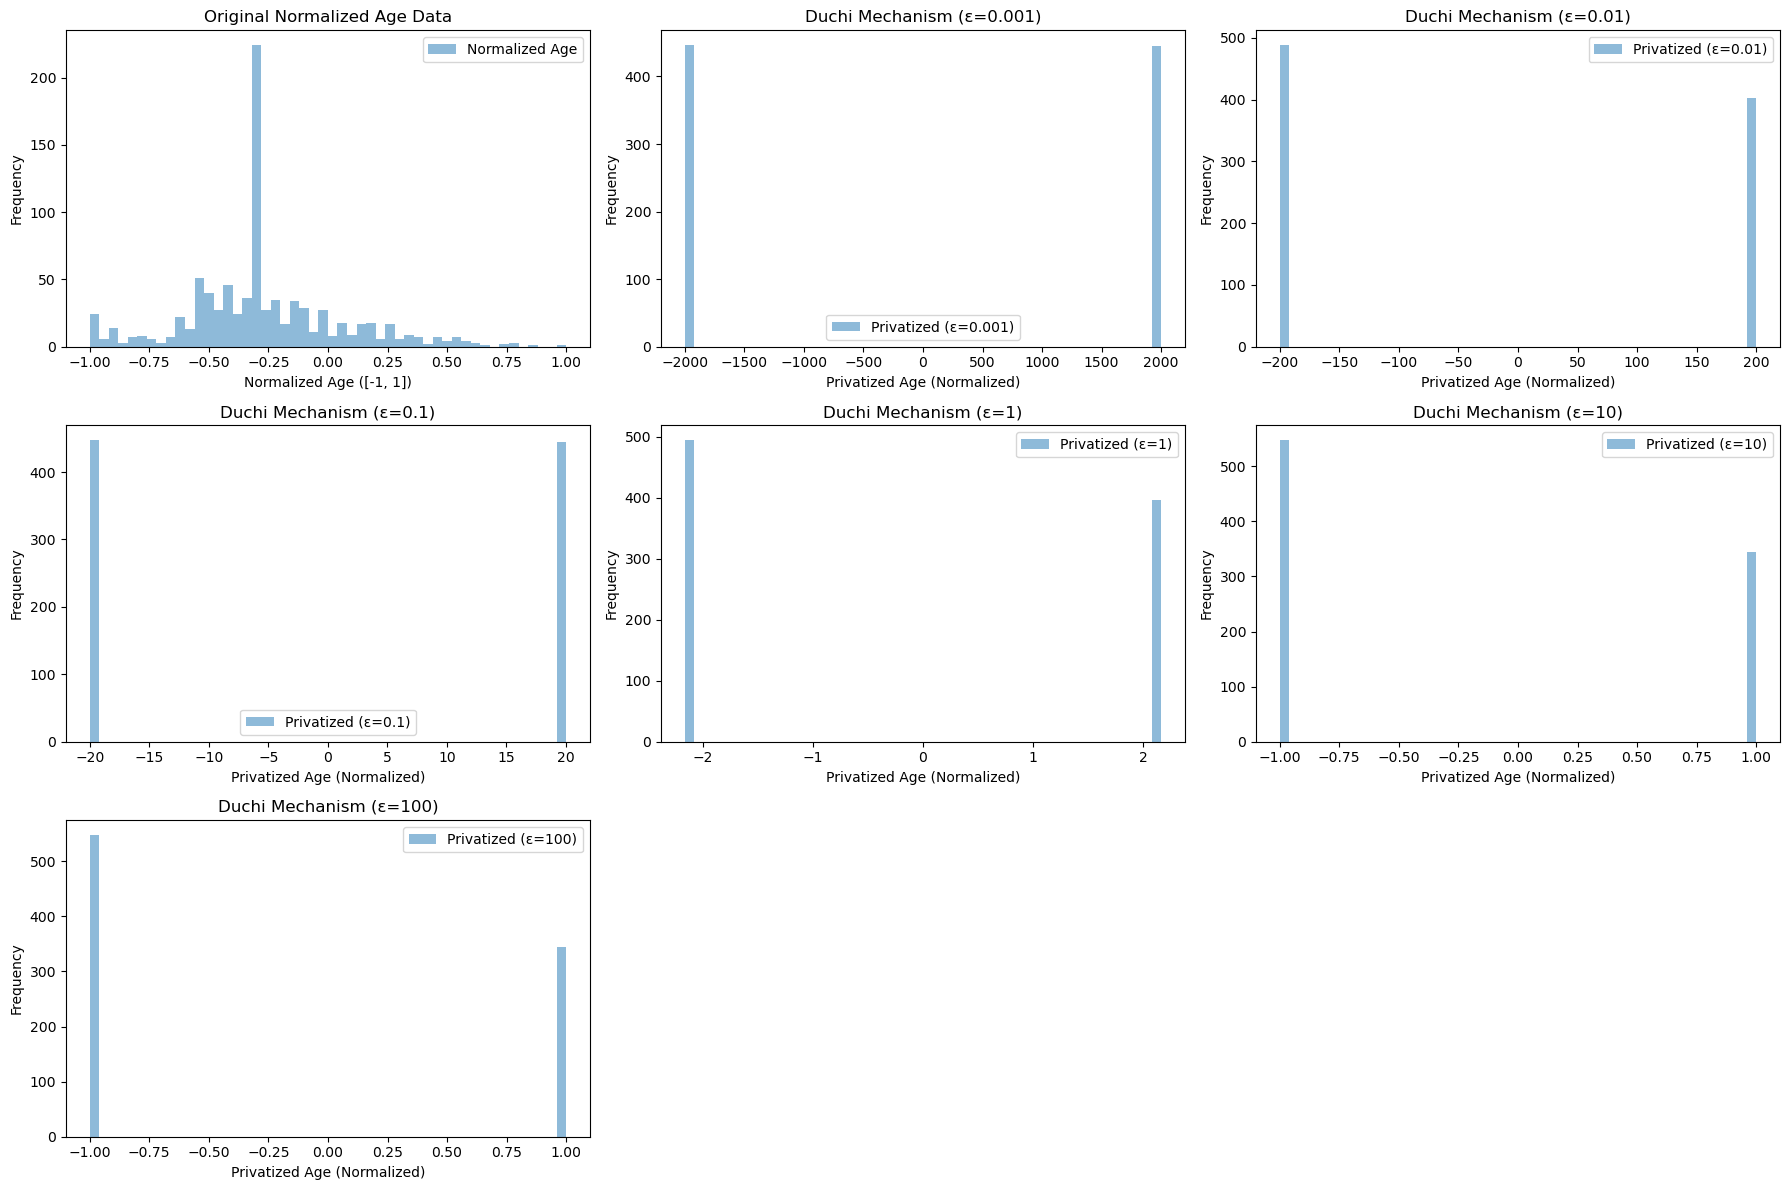

Original Mean Age: -0.2726
Privatized Mean Age: -0.2278


In [24]:
# Set different epsilon values to observe the effect
epsilon_values = [0.001, 0.01, 0.1, 1, 10, 100]

# Plotting
plt.figure(figsize=(18, 12))
plt.subplot(3, 3, 1)
plt.hist(age_normalized.numpy(), bins=50, alpha=0.5, label='Normalized Age')
plt.xlabel('Normalized Age ([-1, 1])')
plt.ylabel('Frequency')
plt.title('Original Normalized Age Data')
plt.legend()

# Apply Duchi Mechanism for each epsilon and plot
for i, epsilon in enumerate(epsilon_values, start=2):
    duchi_priv = duchi_mechanism(age_normalized, epsilon)
    plt.subplot(3, 3, i)
    plt.hist(duchi_priv.numpy(), bins=50, alpha=0.5, label=f'Privatized (ε={epsilon})')
    plt.xlabel('Privatized Age (Normalized)')
    plt.ylabel('Frequency')
    plt.title(f'Duchi Mechanism (ε={epsilon})')
    plt.legend()
    print(f'ε={epsilon}: {duchi_priv.mean():.4f}')
    

plt.tight_layout()
plt.show()

#calculate the mean of duchi_priv
mean_age = age_normalized.mean()
mean_age_priv = duchi_priv.mean()
print(f'Original Mean Age: {mean_age:.4f}')
print(f'Privatized Mean Age: {mean_age_priv:.4f}')


Here we observe that as the duchi mechanism is a discrete algorith that takes only two values in the distribution, When ϵϵ is very low (e.g., 0.0010.001), the values are extremely large, showing a range from around −2000−2000 to 20002000.
For slightly larger ϵϵ (e.g., 0.010.01), the values are still highly polarized, with ranges around [−200,200][−200,200].
At ϵ=0.1ϵ=0.1, the values are slightly closer but still concentrated at the extremes, approximately [−20,20][−20,20].
This behavior illustrates the effect of strong noise due to the small ϵϵ, causing high variance and discrete values.As ϵϵ increases, the distribution of transformed values moves closer to the original range of [−1,1][−1,1].

C:\Users\David\AppData\Local\Temp\ipykernel_18584\751305058.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u = torch.bernoulli(torch.tensor(prob_u))


ε=0.001: -0.0438
ε=0.01: 0.0550
ε=0.1: 0.0483
ε=1: -0.0887
ε=10: 0.0303
ε=50: -0.0191


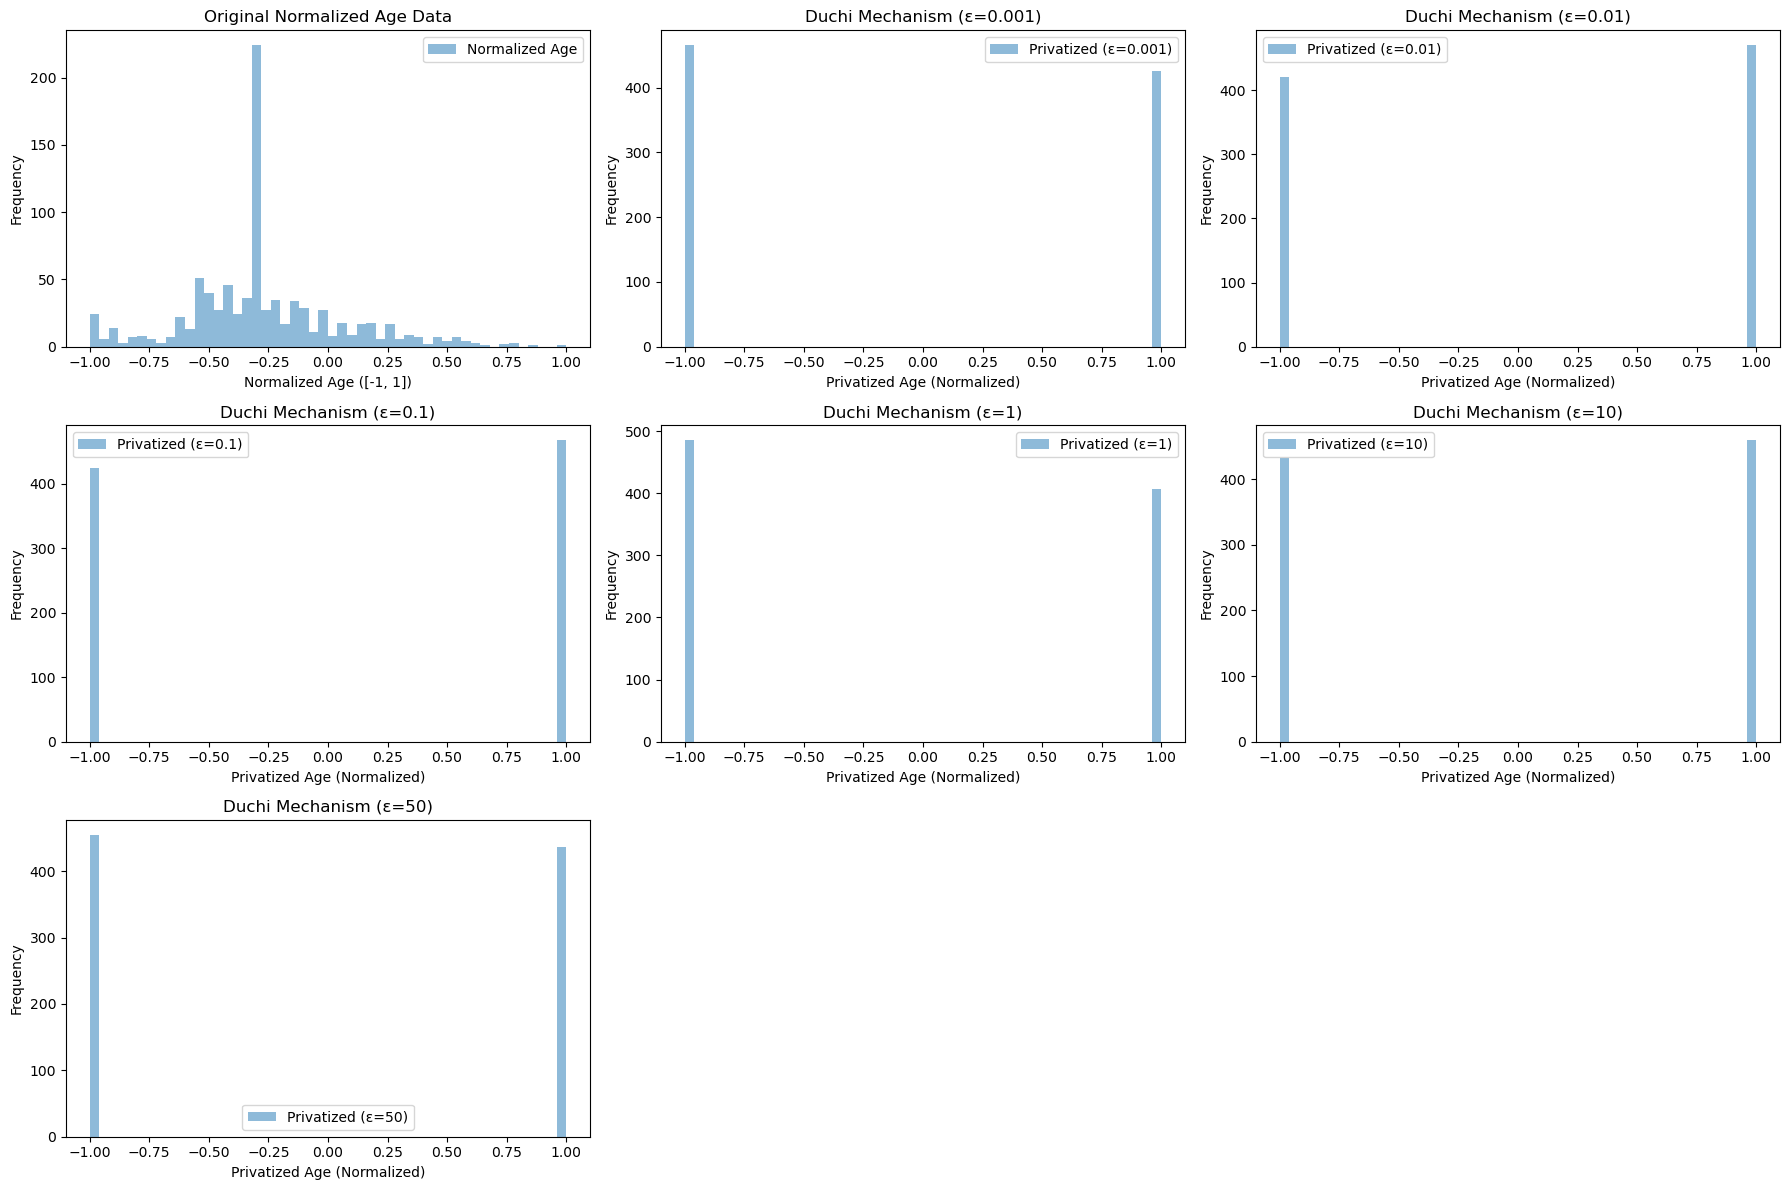

Original Mean Age: -0.2726
Privatized Mean Age: -0.0191


In [26]:


# Set different epsilon values to observe the effect
epsilon_values = [0.001, 0.01, 0.1, 1, 10, 50]

# Plotting
plt.figure(figsize=(18, 12))
plt.subplot(3, 3, 1)
plt.hist(age_normalized.numpy(), bins=50, alpha=0.5, label='Normalized Age')
plt.xlabel('Normalized Age ([-1, 1])')
plt.ylabel('Frequency')
plt.title('Original Normalized Age Data')
plt.legend()

# Apply Duchi Mechanism for each epsilon and plot
for i, epsilon in enumerate(epsilon_values, start=2):
    duchi_priv = multidimensional_duchi_mechanism(age_normalized, epsilon)
    plt.subplot(3, 3, i)
    plt.hist(duchi_priv.numpy(), bins=50, alpha=0.5, label=f'Privatized (ε={epsilon})')
    plt.xlabel('Privatized Age (Normalized)')
    plt.ylabel('Frequency')
    plt.title(f'Duchi Mechanism (ε={epsilon})')
    plt.legend()
    print(f'ε={epsilon}: {duchi_priv.mean():.4f}')
    

plt.tight_layout()
plt.show()

#calculate the mean of duchi_priv
mean_age = age_normalized.mean()
mean_age_priv = duchi_priv.mean()
print(f'Original Mean Age: {mean_age:.4f}')
print(f'Privatized Mean Age: {mean_age_priv:.4f}')


This algorithm is the new of the paper (Collecting and Analyzing Multidimensional Data
with Local Differential Privacy) is the algorithm 4 their new method that combines que duchi solution with the piecewise method. AS wee see for some vlaues of the distribution it appear as the duchi solution, but with larger values appers to transfor it in the piecewise method, convert this algorithma a s hibrid combination. 

c:\Users\David\Documents\DifPrivHealthCostPredict\python_class\dp_mechanisms\quantitative.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e_epsilon_2 = torch.exp(torch.tensor(epsilon / 2.0))


Privatized Mean Age (ε=0.0010000000474974513): -0.0887
Privatized Mean Age (ε=0.009999999776482582): -0.2076
Privatized Mean Age (ε=0.10000000149011612): -0.1259
Privatized Mean Age (ε=1.0): -0.2616
Privatized Mean Age (ε=10.0): -0.2737
Privatized Mean Age (ε=50.0): -0.2726


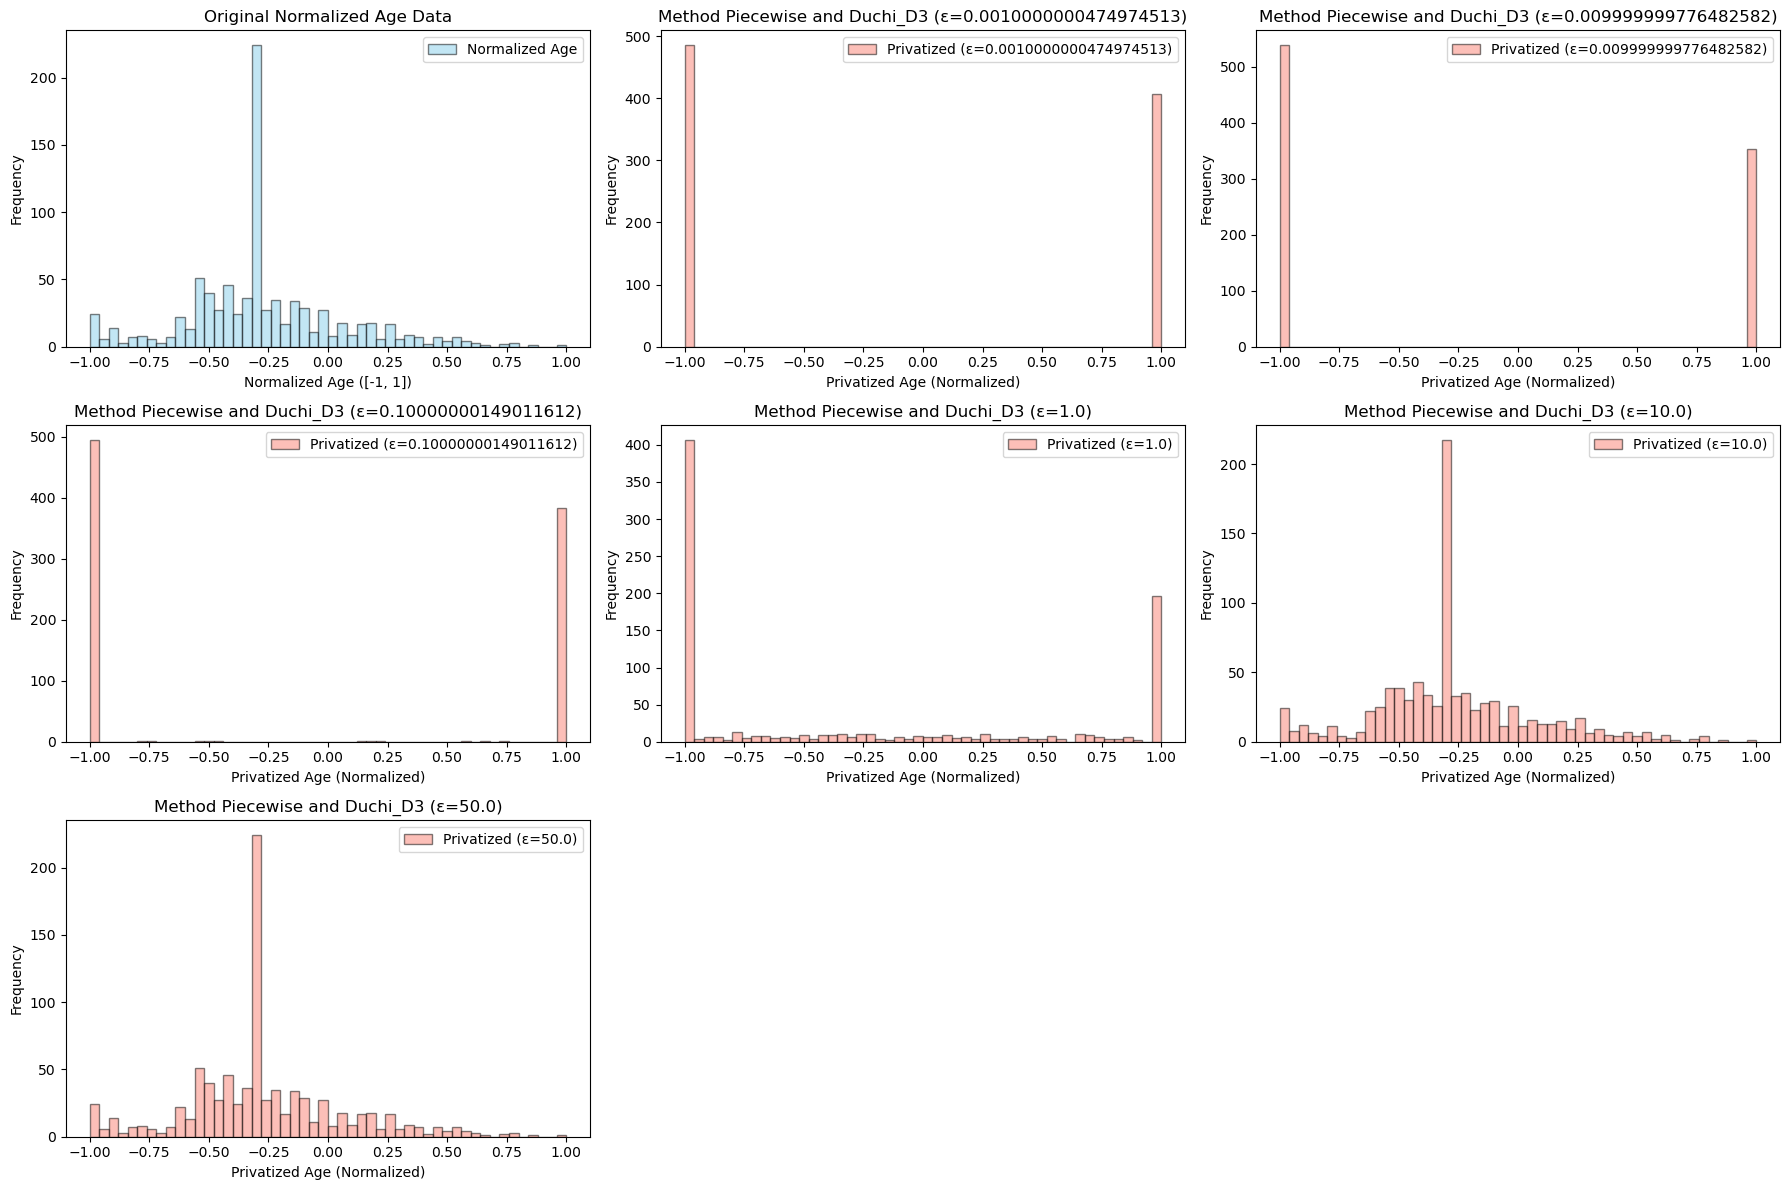

tensor(-0.2726)


In [28]:

epsilon_values = [0.001, 0.01, 0.1, 1, 10, 50]
epsilon_values = torch.tensor(epsilon_values)
dimension = 10

# Plot original data
plt.figure(figsize=(18, 12))
plt.subplot(3, 3, 1)
plt.hist(age_normalized.numpy(), bins=50, alpha=0.5, color='skyblue', edgecolor='black', label='Normalized Age')
plt.xlabel('Normalized Age ([-1, 1])')
plt.ylabel('Frequency')
plt.title('Original Normalized Age Data')
plt.legend()

# Apply Duchi Mechanism for each epsilon and plot
for i, epsilon in enumerate(epsilon_values, start=2):
    duchi_priv = multidimensional_mechanism(age_normalized, epsilon)
    plt.subplot(3, 3, i)
    plt.hist(duchi_priv.numpy(), bins=50, alpha=0.5, color='salmon', edgecolor='black', label=f'Privatized (ε={epsilon.item()})')
    plt.xlabel('Privatized Age (Normalized)')
    plt.ylabel('Frequency')
    plt.title(f'Method Piecewise and Duchi_D3 (ε={epsilon.item()})')
    plt.legend()
    print(f'Privatized Mean Age (ε={epsilon.item()}): {duchi_priv.mean().item():.4f}')

plt.tight_layout()
plt.show()

print(age_normalized.mean())
